In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [7]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [8]:
output_size = y_table.shape[0]

In [9]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [10]:
input_shape = x_test_2d_norm[0].shape

In [11]:
def build_2d_cnn_only_conv_ch_32_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [12]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 253, 95, 32)       832       
_________________________________________________________________
activation (Activation)      (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 195072)            0         
_________________________________________________________________
dropout (Dropout)    

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5382 - acc: 0.5377
Epoch 00001: val_loss improved from inf to 1.32974, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_1_conv_checkpoint/001-1.3297.hdf5
36805/36805 [==============================] - 19s 509us/sample - loss: 1.5381 - acc: 0.5377 - val_loss: 1.3297 - val_acc: 0.6024
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1425 - acc: 0.6593
Epoch 00002: val_loss improved from 1.32974 to 1.19325, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_1_conv_checkpoint/002-1.1932.hdf5
36805/36805 [==============================] - 17s 456us/sample - loss: 1.1428 - acc: 0.6592 - val_loss: 1.1932 - val_acc: 0.6625
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9536 - acc: 0.7148
Epoch 00003: val_loss improved from 1.19325 to 1.09154, savin

36800/36805 [============================>.] - ETA: 0s - loss: 0.1994 - acc: 0.9398
Epoch 00027: val_loss did not improve from 1.02654
36805/36805 [==============================] - 16s 443us/sample - loss: 0.1994 - acc: 0.9398 - val_loss: 1.2576 - val_acc: 0.7601
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1914 - acc: 0.9429
Epoch 00028: val_loss did not improve from 1.02654
36805/36805 [==============================] - 16s 443us/sample - loss: 0.1914 - acc: 0.9429 - val_loss: 1.2570 - val_acc: 0.7575
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1872 - acc: 0.9438
Epoch 00029: val_loss did not improve from 1.02654
36805/36805 [==============================] - 16s 442us/sample - loss: 0.1875 - acc: 0.9438 - val_loss: 1.2822 - val_acc: 0.7510
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.9469
Epoch 00030: val_loss did not improve from 1.02654
36805/36805 [==================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9688
Epoch 00057: val_loss did not improve from 1.02654
36805/36805 [==============================] - 17s 449us/sample - loss: 0.1079 - acc: 0.9688 - val_loss: 1.4878 - val_acc: 0.7596
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9701
Epoch 00058: val_loss did not improve from 1.02654
36805/36805 [==============================] - 16s 448us/sample - loss: 0.1043 - acc: 0.9702 - val_loss: 1.5199 - val_acc: 0.7536
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1037 - acc: 0.9700
Epoch 00059: val_loss did not improve from 1.02654
36805/36805 [==============================] - 17s 451us/sample - loss: 0.1037 - acc: 0.9700 - val_loss: 1.5504 - val_acc: 0.7508

2D_CNN_only_conv_ch_32_DO_1_conv Model


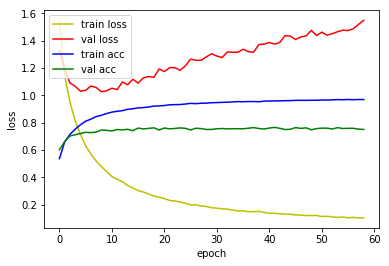

4815/4815 [==============================] - 1s 234us/sample - loss: 1.1429 - acc: 0.7099
Loss: 1.1429275806571588 Accuracy: 0.70986503

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5182 - acc: 0.5391
Epoch 00001: val_loss improved from inf to 1.10332, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_2_conv_checkpoint/001-1.1033.hdf5
36805/36805 [==============================] - 20s 530us/sample - loss: 1.5184 - acc: 0.5391 - val_loss: 1.1033 - val_acc: 0.6939
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9629 - acc: 0.7124
Epoch 00002: val_loss improved from 1.10332 to 0.81644, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_2_conv_checkpoint/002-0.8164.hdf5
36805/36805 [==============================] - 18s 497us/sample - loss: 0.9630 - acc: 0.7124 - val_loss: 0.8164 - val_acc: 0.7817
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9663
Epoch 00026: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 496us/sample - loss: 0.1097 - acc: 0.9663 - val_loss: 0.4949 - val_acc: 0.9057
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1062 - acc: 0.9671
Epoch 00027: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 494us/sample - loss: 0.1062 - acc: 0.9671 - val_loss: 0.5047 - val_acc: 0.9012
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9696
Epoch 00028: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 495us/sample - loss: 0.0986 - acc: 0.9697 - val_loss: 0.5152 - val_acc: 0.9022
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9697
Epoch 00029: val_loss did not improve from 0.45867
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9856
Epoch 00056: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 495us/sample - loss: 0.0478 - acc: 0.9856 - val_loss: 0.5780 - val_acc: 0.9036
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9865
Epoch 00057: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 496us/sample - loss: 0.0454 - acc: 0.9865 - val_loss: 0.5720 - val_acc: 0.9024
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9862
Epoch 00058: val_loss did not improve from 0.45867
36805/36805 [==============================] - 18s 494us/sample - loss: 0.0502 - acc: 0.9862 - val_loss: 0.5885 - val_acc: 0.9052
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9875
Epoch 00059: val_loss did not improve from 0.45867
36805/36805 [=====

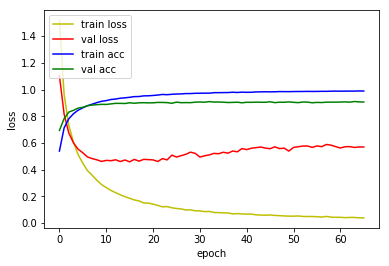

4815/4815 [==============================] - 1s 265us/sample - loss: 0.5499 - acc: 0.8648
Loss: 0.5498564678436747 Accuracy: 0.86479753

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5729 - acc: 0.5135
Epoch 00001: val_loss improved from inf to 0.94064, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_3_conv_checkpoint/001-0.9406.hdf5
36805/36805 [==============================] - 21s 570us/sample - loss: 1.5728 - acc: 0.5135 - val_loss: 0.9406 - val_acc: 0.7459
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8544 - acc: 0.7435
Epoch 00002: val_loss improved from 0.94064 to 0.59847, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_3_conv_checkpoint/002-0.5985.hdf5
36805/36805 [==============================] - 20s 534us/sample - loss: 0.8544 - acc: 0.7435 - val_loss: 0.5985 - val_acc: 0.8449
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9654
Epoch 00024: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 540us/sample - loss: 0.1062 - acc: 0.9654 - val_loss: 0.2481 - val_acc: 0.9411
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9678
Epoch 00025: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 535us/sample - loss: 0.1015 - acc: 0.9678 - val_loss: 0.2472 - val_acc: 0.9443
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9684
Epoch 00026: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 540us/sample - loss: 0.0959 - acc: 0.9684 - val_loss: 0.2562 - val_acc: 0.9441
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9696
Epoch 00027: val_loss did not improve from 0.23454
36805/36805 [==================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9839
Epoch 00054: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 537us/sample - loss: 0.0498 - acc: 0.9839 - val_loss: 0.2666 - val_acc: 0.9495
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9826
Epoch 00055: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 539us/sample - loss: 0.0531 - acc: 0.9826 - val_loss: 0.2922 - val_acc: 0.9481
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9851
Epoch 00056: val_loss did not improve from 0.23454
36805/36805 [==============================] - 20s 541us/sample - loss: 0.0475 - acc: 0.9851 - val_loss: 0.2710 - val_acc: 0.9492
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9849
Epoch 00057: val_loss did not improve from 0.23454
36805/36805 [=====

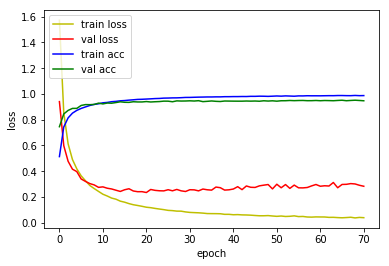

4815/4815 [==============================] - 1s 301us/sample - loss: 0.3244 - acc: 0.9126
Loss: 0.32435973173980276 Accuracy: 0.9125649

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8496 - acc: 0.4108
Epoch 00001: val_loss improved from inf to 1.02945, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_4_conv_checkpoint/001-1.0295.hdf5
36805/36805 [==============================] - 22s 596us/sample - loss: 1.8496 - acc: 0.4108 - val_loss: 1.0295 - val_acc: 0.7032
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0410 - acc: 0.6723
Epoch 00002: val_loss improved from 1.02945 to 0.64948, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_4_conv_checkpoint/002-0.6495.hdf5
36805/36805 [==============================] - 21s 559us/sample - loss: 1.0410 - acc: 0.6723 - val_loss: 0.6495 - val_acc: 0.8157
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9476
Epoch 00023: val_loss did not improve from 0.18479
36805/36805 [==============================] - 21s 559us/sample - loss: 0.1621 - acc: 0.9476 - val_loss: 0.1909 - val_acc: 0.9513
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1580 - acc: 0.9483
Epoch 00024: val_loss improved from 0.18479 to 0.18453, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_4_conv_checkpoint/024-0.1845.hdf5
36805/36805 [==============================] - 21s 563us/sample - loss: 0.1581 - acc: 0.9482 - val_loss: 0.1845 - val_acc: 0.9522
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9499
Epoch 00025: val_loss improved from 0.18453 to 0.17925, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_4_conv_checkpoint/025-0.1793.hdf5
36805/36805 [==============================] - 21s 558us/sample - loss: 0.1535 - acc: 0.9499 - val_loss: 0.1793 -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0764 - acc: 0.9743
Epoch 00050: val_loss did not improve from 0.16262
36805/36805 [==============================] - 20s 554us/sample - loss: 0.0764 - acc: 0.9744 - val_loss: 0.1762 - val_acc: 0.9585
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9751
Epoch 00051: val_loss did not improve from 0.16262
36805/36805 [==============================] - 20s 555us/sample - loss: 0.0733 - acc: 0.9751 - val_loss: 0.1777 - val_acc: 0.9567
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9746
Epoch 00052: val_loss did not improve from 0.16262
36805/36805 [==============================] - 20s 555us/sample - loss: 0.0742 - acc: 0.9747 - val_loss: 0.1922 - val_acc: 0.9590
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9760
Epoch 00053: val_loss did not improve from 0.16262
36805/36805 [=====

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9844
Epoch 00080: val_loss did not improve from 0.16262
36805/36805 [==============================] - 20s 550us/sample - loss: 0.0480 - acc: 0.9844 - val_loss: 0.2051 - val_acc: 0.9583
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9846
Epoch 00081: val_loss did not improve from 0.16262
36805/36805 [==============================] - 20s 554us/sample - loss: 0.0473 - acc: 0.9846 - val_loss: 0.2173 - val_acc: 0.9590
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9837
Epoch 00082: val_loss did not improve from 0.16262
36805/36805 [==============================] - 21s 559us/sample - loss: 0.0515 - acc: 0.9837 - val_loss: 0.2123 - val_acc: 0.9590
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9837
Epoch 00083: val_loss did not improve from 0.16262
36805/36805 [=====

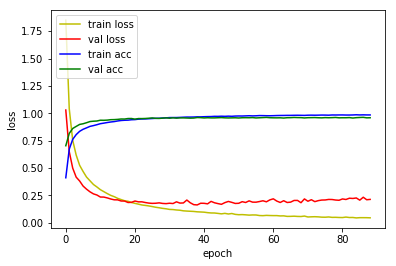

4815/4815 [==============================] - 2s 322us/sample - loss: 0.2328 - acc: 0.9360
Loss: 0.23281810850616805 Accuracy: 0.93603325



In [13]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_32_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_32_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
activation_10 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 195072)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 195072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 

In [16]:
def build_2d_cnn_only_conv_ch_32_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [17]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 32)       128       
_________________________________________________________________
activation_20 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 195072)            0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 195072)            780288    
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1498 - acc: 0.5460
Epoch 00001: val_loss improved from inf to 1.65534, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_1_conv_checkpoint/001-1.6553.hdf5
36805/36805 [==============================] - 26s 694us/sample - loss: 2.1499 - acc: 0.5459 - val_loss: 1.6553 - val_acc: 0.6164
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9707 - acc: 0.7618
Epoch 00002: val_loss did not improve from 1.65534
36805/36805 [==============================] - 22s 609us/sample - loss: 0.9711 - acc: 0.7618 - val_loss: 1.7016 - val_acc: 0.6587
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5626 - acc: 0.8481
Epoch 00003: val_loss improved from 1.65534 to 1.65040, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_1_conv_checkpoint/003-1.6504.hdf5
36805/36805 [==============================] - 23s 615us/s

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9816
Epoch 00030: val_loss did not improve from 1.65040
36805/36805 [==============================] - 22s 610us/sample - loss: 0.0903 - acc: 0.9816 - val_loss: 2.6985 - val_acc: 0.6832
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9849
Epoch 00031: val_loss did not improve from 1.65040
36805/36805 [==============================] - 22s 611us/sample - loss: 0.0779 - acc: 0.9849 - val_loss: 2.8285 - val_acc: 0.6748
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9849
Epoch 00032: val_loss did not improve from 1.65040
36805/36805 [==============================] - 23s 612us/sample - loss: 0.0735 - acc: 0.9849 - val_loss: 2.7798 - val_acc: 0.6774
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9864
Epoch 00033: val_loss did not improve from 1.65040
36805/36805 [=====

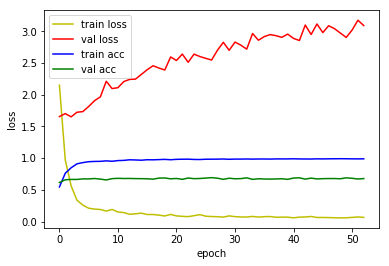

4815/4815 [==============================] - 2s 316us/sample - loss: 1.8948 - acc: 0.6428
Loss: 1.8947815366746976 Accuracy: 0.642783

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4444 - acc: 0.5920
Epoch 00001: val_loss improved from inf to 1.10262, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_2_conv_checkpoint/001-1.1026.hdf5
36805/36805 [==============================] - 29s 795us/sample - loss: 1.4444 - acc: 0.5920 - val_loss: 1.1026 - val_acc: 0.6879
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7399 - acc: 0.7828
Epoch 00002: val_loss improved from 1.10262 to 0.92340, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_2_conv_checkpoint/002-0.9234.hdf5
36805/36805 [==============================] - 26s 694us/sample - loss: 0.7395 - acc: 0.7829 - val_loss: 0.9234 - val_acc: 0.7468
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - l

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9949
Epoch 00028: val_loss did not improve from 0.62518
36805/36805 [==============================] - 25s 684us/sample - loss: 0.0228 - acc: 0.9948 - val_loss: 1.2986 - val_acc: 0.7685
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9935
Epoch 00029: val_loss did not improve from 0.62518
36805/36805 [==============================] - 25s 680us/sample - loss: 0.0271 - acc: 0.9935 - val_loss: 0.9416 - val_acc: 0.8223
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9976
Epoch 00030: val_loss did not improve from 0.62518
36805/36805 [==============================] - 25s 682us/sample - loss: 0.0126 - acc: 0.9976 - val_loss: 0.8331 - val_acc: 0.8565
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9965
Epoch 00031: val_loss did not improve from 0.62518
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9979
Epoch 00058: val_loss did not improve from 0.62518
36805/36805 [==============================] - 25s 687us/sample - loss: 0.0087 - acc: 0.9979 - val_loss: 0.9501 - val_acc: 0.8498

2D_CNN_only_conv_ch_32_BN_2_conv Model


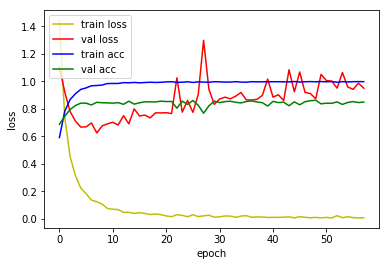

4815/4815 [==============================] - 2s 360us/sample - loss: 0.7362 - acc: 0.8123
Loss: 0.7361935867079817 Accuracy: 0.81225336

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3980 - acc: 0.5837
Epoch 00001: val_loss improved from inf to 0.96685, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_3_conv_checkpoint/001-0.9669.hdf5
36805/36805 [==============================] - 33s 884us/sample - loss: 1.3974 - acc: 0.5838 - val_loss: 0.9669 - val_acc: 0.7279
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7123 - acc: 0.7930
Epoch 00002: val_loss improved from 0.96685 to 0.63911, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_3_conv_checkpoint/002-0.6391.hdf5
36805/36805 [==============================] - 27s 739us/sample - loss: 0.7120 - acc: 0.7931 - val_loss: 0.6391 - val_acc: 0.8120
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9925
Epoch 00027: val_loss did not improve from 0.31979
36805/36805 [==============================] - 27s 743us/sample - loss: 0.0316 - acc: 0.9925 - val_loss: 0.3804 - val_acc: 0.9136
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9945
Epoch 00028: val_loss did not improve from 0.31979
36805/36805 [==============================] - 27s 742us/sample - loss: 0.0262 - acc: 0.9945 - val_loss: 0.3612 - val_acc: 0.9194
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9945
Epoch 00029: val_loss did not improve from 0.31979
36805/36805 [==============================] - 27s 740us/sample - loss: 0.0252 - acc: 0.9944 - val_loss: 0.3775 - val_acc: 0.9152
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9944
Epoch 00030: val_loss did not improve from 0.31979
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9949
Epoch 00057: val_loss did not improve from 0.31979
36805/36805 [==============================] - 27s 743us/sample - loss: 0.0186 - acc: 0.9949 - val_loss: 0.3692 - val_acc: 0.9259
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9985
Epoch 00058: val_loss did not improve from 0.31979
36805/36805 [==============================] - 28s 748us/sample - loss: 0.0085 - acc: 0.9984 - val_loss: 0.4077 - val_acc: 0.9182
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9956
Epoch 00059: val_loss did not improve from 0.31979
36805/36805 [==============================] - 27s 742us/sample - loss: 0.0202 - acc: 0.9956 - val_loss: 0.3585 - val_acc: 0.9299
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9986
Epoch 00060: val_loss did not improve from 0.31979
36805/36805 [=====

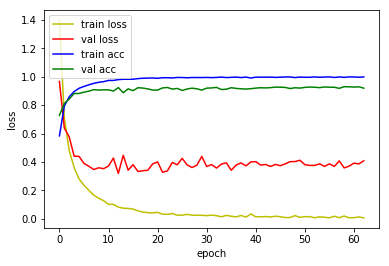

4815/4815 [==============================] - 2s 380us/sample - loss: 0.4196 - acc: 0.8872
Loss: 0.4196391498807311 Accuracy: 0.8872274

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6120 - acc: 0.5107
Epoch 00001: val_loss improved from inf to 1.07953, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_4_conv_checkpoint/001-1.0795.hdf5
36805/36805 [==============================] - 35s 954us/sample - loss: 1.6115 - acc: 0.5108 - val_loss: 1.0795 - val_acc: 0.6550
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7930 - acc: 0.7640
Epoch 00002: val_loss improved from 1.07953 to 0.59565, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_BN_4_conv_checkpoint/002-0.5957.hdf5
36805/36805 [==============================] - 29s 778us/sample - loss: 0.7925 - acc: 0.7641 - val_loss: 0.5957 - val_acc: 0.8286
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9903
Epoch 00025: val_loss did not improve from 0.20678
36805/36805 [==============================] - 29s 785us/sample - loss: 0.0431 - acc: 0.9903 - val_loss: 0.2831 - val_acc: 0.9215
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9908
Epoch 00026: val_loss did not improve from 0.20678
36805/36805 [==============================] - 29s 779us/sample - loss: 0.0424 - acc: 0.9908 - val_loss: 0.2469 - val_acc: 0.9331
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9878
Epoch 00027: val_loss did not improve from 0.20678
36805/36805 [==============================] - 29s 783us/sample - loss: 0.0493 - acc: 0.9878 - val_loss: 0.2276 - val_acc: 0.9387
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9908
Epoch 00028: val_loss did not improve from 0.20678
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9970
Epoch 00054: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 782us/sample - loss: 0.0137 - acc: 0.9970 - val_loss: 0.2300 - val_acc: 0.9446
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9972
Epoch 00055: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 785us/sample - loss: 0.0133 - acc: 0.9972 - val_loss: 0.2597 - val_acc: 0.9401
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9972
Epoch 00056: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 780us/sample - loss: 0.0132 - acc: 0.9972 - val_loss: 0.2382 - val_acc: 0.9443
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9971
Epoch 00057: val_loss did not improve from 0.19635
36805/36805 [==================

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9989
Epoch 00084: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 780us/sample - loss: 0.0065 - acc: 0.9989 - val_loss: 0.2349 - val_acc: 0.9483
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9961
Epoch 00085: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 782us/sample - loss: 0.0144 - acc: 0.9961 - val_loss: 0.2208 - val_acc: 0.9515
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9989
Epoch 00086: val_loss did not improve from 0.19635
36805/36805 [==============================] - 29s 785us/sample - loss: 0.0058 - acc: 0.9988 - val_loss: 0.2338 - val_acc: 0.9485
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9983
Epoch 00087: val_loss did not improve from 0.19635
36805/36805 [=====

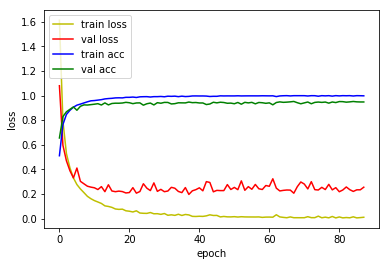

4815/4815 [==============================] - 2s 406us/sample - loss: 0.2697 - acc: 0.9225
Loss: 0.2697078215029876 Accuracy: 0.92253375



In [18]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_32_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_32_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_32_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1_14 (B (None, 253, 95, 32)       128       
_________________________________________________________________
activation_30 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 195072)            0         
_________________________________________________________________
batch_normalization_v1_15 (B (None, 

4815/4815 [==============================] - 2s 434us/sample - loss: 0.2697 - acc: 0.9225
Loss: 0.2697078215029876 Accuracy: 0.92253375


In [20]:
def build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [21]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 253, 95, 32)       128       
_________________________________________________________________
activation_40 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 195072)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 195072)            0         
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1503 - acc: 0.4820
Epoch 00001: val_loss improved from inf to 1.76284, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_1_conv_checkpoint/001-1.7628.hdf5
36805/36805 [==============================] - 28s 756us/sample - loss: 2.1502 - acc: 0.4820 - val_loss: 1.7628 - val_acc: 0.5535
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5610 - acc: 0.6013
Epoch 00002: val_loss improved from 1.76284 to 1.61247, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_1_conv_checkpoint/002-1.6125.hdf5
36805/36805 [==============================] - 21s 579us/sample - loss: 1.5611 - acc: 0.6013 - val_loss: 1.6125 - val_acc: 0.6177
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2343 - acc: 0.6724
Epoch 00003: val_loss improved from 1.61247 to 1.55405, saving model to model/checkpoint/2D_CNN_only_co

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2668 - acc: 0.9252
Epoch 00028: val_loss did not improve from 1.39332
36805/36805 [==============================] - 21s 579us/sample - loss: 0.2667 - acc: 0.9252 - val_loss: 1.7310 - val_acc: 0.7363
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2687 - acc: 0.9235
Epoch 00029: val_loss did not improve from 1.39332
36805/36805 [==============================] - 21s 580us/sample - loss: 0.2687 - acc: 0.9235 - val_loss: 1.7095 - val_acc: 0.7277
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2497 - acc: 0.9304
Epoch 00030: val_loss did not improve from 1.39332
36805/36805 [==============================] - 21s 580us/sample - loss: 0.2497 - acc: 0.9304 - val_loss: 1.6956 - val_acc: 0.7372
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2475 - acc: 0.9311
Epoch 00031: val_loss did not improve from 1.39332
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9563
Epoch 00058: val_loss did not improve from 1.39332
36805/36805 [==============================] - 21s 577us/sample - loss: 0.1735 - acc: 0.9563 - val_loss: 1.9068 - val_acc: 0.7428
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1756 - acc: 0.9551
Epoch 00059: val_loss did not improve from 1.39332
36805/36805 [==============================] - 21s 574us/sample - loss: 0.1756 - acc: 0.9551 - val_loss: 1.8798 - val_acc: 0.7421

2D_CNN_only_conv_ch_32_DO_BN_1_conv Model


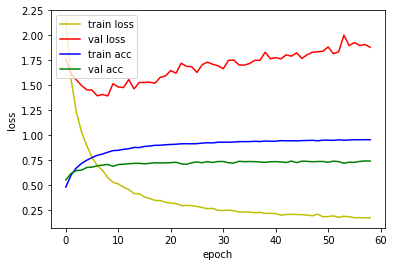

4815/4815 [==============================] - 2s 386us/sample - loss: 1.6229 - acc: 0.6721
Loss: 1.622935887264438 Accuracy: 0.67206645

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7870 - acc: 0.4595
Epoch 00001: val_loss improved from inf to 1.18114, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_2_conv_checkpoint/001-1.1811.hdf5
36805/36805 [==============================] - 33s 891us/sample - loss: 1.7868 - acc: 0.4596 - val_loss: 1.1811 - val_acc: 0.6618
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0913 - acc: 0.6658
Epoch 00002: val_loss improved from 1.18114 to 0.86344, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_2_conv_checkpoint/002-0.8634.hdf5
36805/36805 [==============================] - 25s 687us/sample - loss: 1.0912 - acc: 0.6658 - val_loss: 0.8634 - val_acc: 0.7619
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1601 - acc: 0.9500
Epoch 00025: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 687us/sample - loss: 0.1601 - acc: 0.9500 - val_loss: 0.4976 - val_acc: 0.8866
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9515
Epoch 00026: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 683us/sample - loss: 0.1525 - acc: 0.9514 - val_loss: 0.4941 - val_acc: 0.8903
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1501 - acc: 0.9535
Epoch 00027: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 683us/sample - loss: 0.1502 - acc: 0.9535 - val_loss: 0.5167 - val_acc: 0.8784
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1444 - acc: 0.9548
Epoch 00028: val_loss did not improve from 0.46125
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9757
Epoch 00055: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 683us/sample - loss: 0.0772 - acc: 0.9757 - val_loss: 0.5330 - val_acc: 0.8942
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9787
Epoch 00056: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 684us/sample - loss: 0.0710 - acc: 0.9787 - val_loss: 0.5149 - val_acc: 0.8989
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9799
Epoch 00057: val_loss did not improve from 0.46125
36805/36805 [==============================] - 25s 688us/sample - loss: 0.0688 - acc: 0.9799 - val_loss: 0.5306 - val_acc: 0.8966
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9791
Epoch 00058: val_loss did not improve from 0.46125
36805/36805 [=====

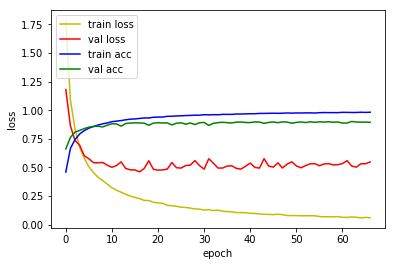

4815/4815 [==============================] - 2s 446us/sample - loss: 0.5361 - acc: 0.8623
Loss: 0.536075967593604 Accuracy: 0.8623053

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7832 - acc: 0.4523
Epoch 00001: val_loss improved from inf to 1.01719, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_3_conv_checkpoint/001-1.0172.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 1.7831 - acc: 0.4524 - val_loss: 1.0172 - val_acc: 0.7037
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9439 - acc: 0.7083
Epoch 00002: val_loss improved from 1.01719 to 0.63158, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_3_conv_checkpoint/002-0.6316.hdf5
36805/36805 [==============================] - 27s 741us/sample - loss: 0.9439 - acc: 0.7083 - val_loss: 0.6316 - val_acc: 0.8225
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s

Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1400 - acc: 0.9564
Epoch 00025: val_loss did not improve from 0.25966
36805/36805 [==============================] - 27s 742us/sample - loss: 0.1400 - acc: 0.9563 - val_loss: 0.2877 - val_acc: 0.9329
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9576
Epoch 00026: val_loss improved from 0.25966 to 0.24861, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_3_conv_checkpoint/026-0.2486.hdf5
36805/36805 [==============================] - 27s 742us/sample - loss: 0.1343 - acc: 0.9575 - val_loss: 0.2486 - val_acc: 0.9429
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9565
Epoch 00027: val_loss did not improve from 0.24861
36805/36805 [==============================] - 27s 741us/sample - loss: 0.1377 - acc: 0.9564 - val_loss: 0.2867 - val_acc: 0.9327
Epoch 28/500
36736/36805 [============================>.] - ETA: 

Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9785
Epoch 00054: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 745us/sample - loss: 0.0682 - acc: 0.9785 - val_loss: 0.2986 - val_acc: 0.9355
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9786
Epoch 00055: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 745us/sample - loss: 0.0682 - acc: 0.9786 - val_loss: 0.3023 - val_acc: 0.9343
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9783
Epoch 00056: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 742us/sample - loss: 0.0679 - acc: 0.9783 - val_loss: 0.4265 - val_acc: 0.9110
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9787
Epoch 00057: val_loss did not improve from 0.24752
36805/36805 [=====

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9858
Epoch 00084: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 740us/sample - loss: 0.0443 - acc: 0.9858 - val_loss: 0.2688 - val_acc: 0.9448
Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9867
Epoch 00085: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 740us/sample - loss: 0.0447 - acc: 0.9867 - val_loss: 0.2927 - val_acc: 0.9464
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9864
Epoch 00086: val_loss did not improve from 0.24752
36805/36805 [==============================] - 27s 740us/sample - loss: 0.0438 - acc: 0.9864 - val_loss: 0.3047 - val_acc: 0.9383
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9877
Epoch 00087: val_loss did not improve from 0.24752
36805/36805 [=====

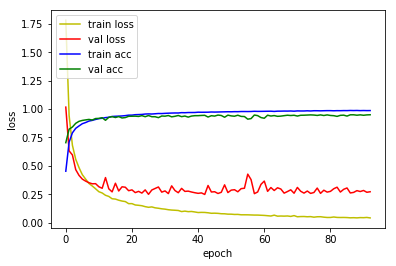

4815/4815 [==============================] - 2s 474us/sample - loss: 0.3144 - acc: 0.9229
Loss: 0.3143982418724805 Accuracy: 0.92294914

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0992 - acc: 0.3517
Epoch 00001: val_loss improved from inf to 1.23297, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_4_conv_checkpoint/001-1.2330.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.0981 - acc: 0.3520 - val_loss: 1.2330 - val_acc: 0.6366
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1547 - acc: 0.6344
Epoch 00002: val_loss improved from 1.23297 to 0.68360, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_DO_BN_4_conv_checkpoint/002-0.6836.hdf5
36805/36805 [==============================] - 28s 755us/sample - loss: 1.1542 - acc: 0.6346 - val_loss: 0.6836 - val_acc: 0.8076
Epoch 3/500
36736/36805 [============================>.] - ETA: 

36736/36805 [============================>.] - ETA: 0s - loss: 0.1433 - acc: 0.9553
Epoch 00024: val_loss did not improve from 0.16171
36805/36805 [==============================] - 28s 759us/sample - loss: 0.1432 - acc: 0.9553 - val_loss: 0.1739 - val_acc: 0.9502
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9558
Epoch 00025: val_loss did not improve from 0.16171
36805/36805 [==============================] - 28s 756us/sample - loss: 0.1401 - acc: 0.9558 - val_loss: 0.1794 - val_acc: 0.9476
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1397 - acc: 0.9559
Epoch 00026: val_loss did not improve from 0.16171
36805/36805 [==============================] - 28s 756us/sample - loss: 0.1398 - acc: 0.9558 - val_loss: 0.1763 - val_acc: 0.9513
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1281 - acc: 0.9601
Epoch 00027: val_loss did not improve from 0.16171
36805/36805 [==================

Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0593 - acc: 0.9810
Epoch 00053: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 757us/sample - loss: 0.0593 - acc: 0.9810 - val_loss: 0.1644 - val_acc: 0.9616
Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9790
Epoch 00054: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 756us/sample - loss: 0.0656 - acc: 0.9790 - val_loss: 0.1548 - val_acc: 0.9618
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9805
Epoch 00055: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 759us/sample - loss: 0.0619 - acc: 0.9805 - val_loss: 0.1699 - val_acc: 0.9590
Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9819
Epoch 00056: val_loss did not improve from 0.14207
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9886
Epoch 00083: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 760us/sample - loss: 0.0377 - acc: 0.9886 - val_loss: 0.1875 - val_acc: 0.9609
Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9888
Epoch 00084: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 760us/sample - loss: 0.0383 - acc: 0.9888 - val_loss: 0.1635 - val_acc: 0.9639
Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9882
Epoch 00085: val_loss did not improve from 0.14207
36805/36805 [==============================] - 28s 758us/sample - loss: 0.0391 - acc: 0.9882 - val_loss: 0.1757 - val_acc: 0.9567
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9886
Epoch 00086: val_loss did not improve from 0.14207
36805/36805 [=====

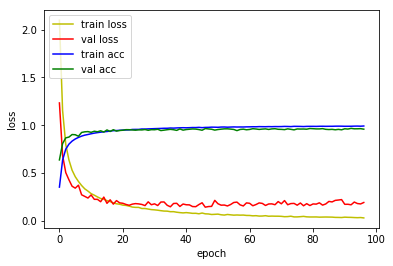

4815/4815 [==============================] - 2s 502us/sample - loss: 0.2300 - acc: 0.9375
Loss: 0.2299849759566821 Accuracy: 0.937487



In [22]:
for i in range(1, 5):
    base = '2D_CNN_only_conv_ch_32_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [23]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '2D_CNN_only_conv_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 5):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


2D_CNN_only_conv_ch_32_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1_38 (B (None, 253, 95, 32)       128       
_________________________________________________________________
activation_50 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 195072)            0         
_________________________________________________________________
dropout_12 (Dropout)         (Non

4815/4815 [==============================] - 2s 517us/sample - loss: 0.2300 - acc: 0.9375
Loss: 0.2299849759566821 Accuracy: 0.937487
